In [7]:
import pandas as pd

file_path = "fmri_features_with_mrs.csv"
data = pd.read_csv(file_path)

data.head()


,subject,session,roi,gsr,mean,variance,total power,power law slope,pcc mrs,sma mrs
0,sub-02,mec01,17Networks_LH_DefaultA_pCunPCC_1,no gsr,1384.084756,11.052421,2.098856e+11,-2.357474,15.29,11.45
1,sub-02,mec01,17Networks_RH_DefaultA_pCunPCC_1,no gsr,1342.522984,13.479230,1.974700e+11,-3.906936,15.29,11.45
2,sub-02,mec01,17Networks_LH_SomMotA_1,no gsr,1528.789775,5.029322,2.560660e+11,-2.895188,15.29,11.45
3,sub-02,mec01,17Networks_LH_SomMotA_2,no gsr,1581.240097,2.665821,2.739377e+11,-1.724240,15.29,11.45
4,sub-02,mec01,17Networks_RH_SomMotA_1,no gsr,2005.650420,6.425380,4.407241e+11,-3.818444,15.29,11.45


In [11]:
import scipy.io as sio
pcc_mrs_mat = sio.loadmat('PCC_new.mat')
pcc_mrs = pcc_mrs_mat['PCC']

sma_mrs_mat = sio.loadmat('SMA_new.mat')
sma_mrs = sma_mrs_mat['SMA']

pcc_mrs

array([[15.29 , 15.55 , 15.62 , 16.51 , 15.88 , 14.98 , 15.46 , 16.1  ,
        15.03 , 15.05 , 15.97 ],
       [15.43 , 14.   , 13.5  , 13.62 , 11.92 ,  9.127, 10.75 , 11.03 ,
           nan,  9.414,  7.814],
       [ 4.799, 14.6  , 11.11 , 13.78 , 13.25 , 14.64 , 13.27 , 14.93 ,
        13.42 , 14.1  , 15.61 ],
       [ 8.984, 10.63 , 13.62 ,    nan,    nan,  5.614, 14.38 , 14.42 ,
        14.83 , 15.02 , 15.33 ],
       [16.09 , 15.25 , 15.41 , 15.5  , 14.49 , 14.89 , 15.19 , 14.15 ,
        15.13 , 15.55 , 14.07 ],
       [12.32 , 14.76 , 13.98 , 13.91 , 12.51 , 11.2  , 14.31 , 13.58 ,
        15.14 , 14.5  , 12.17 ]])

In [12]:
mean_values = data[(data["roi"]=="17Networks_LH_DefaultA_pCunPCC_1") 
           & (data["subject"]=="sub-02") 
           & (data["gsr"]=="no gsr")]["mean"].to_numpy()

mean_values

array([1384.08475552, 1222.53898579, 1281.25907438, 1176.28576845,
       1343.55179875, 1228.47090204, 1202.21622672, 1245.46425553,
       1259.93342337, 1228.87319174, 1304.91437081])

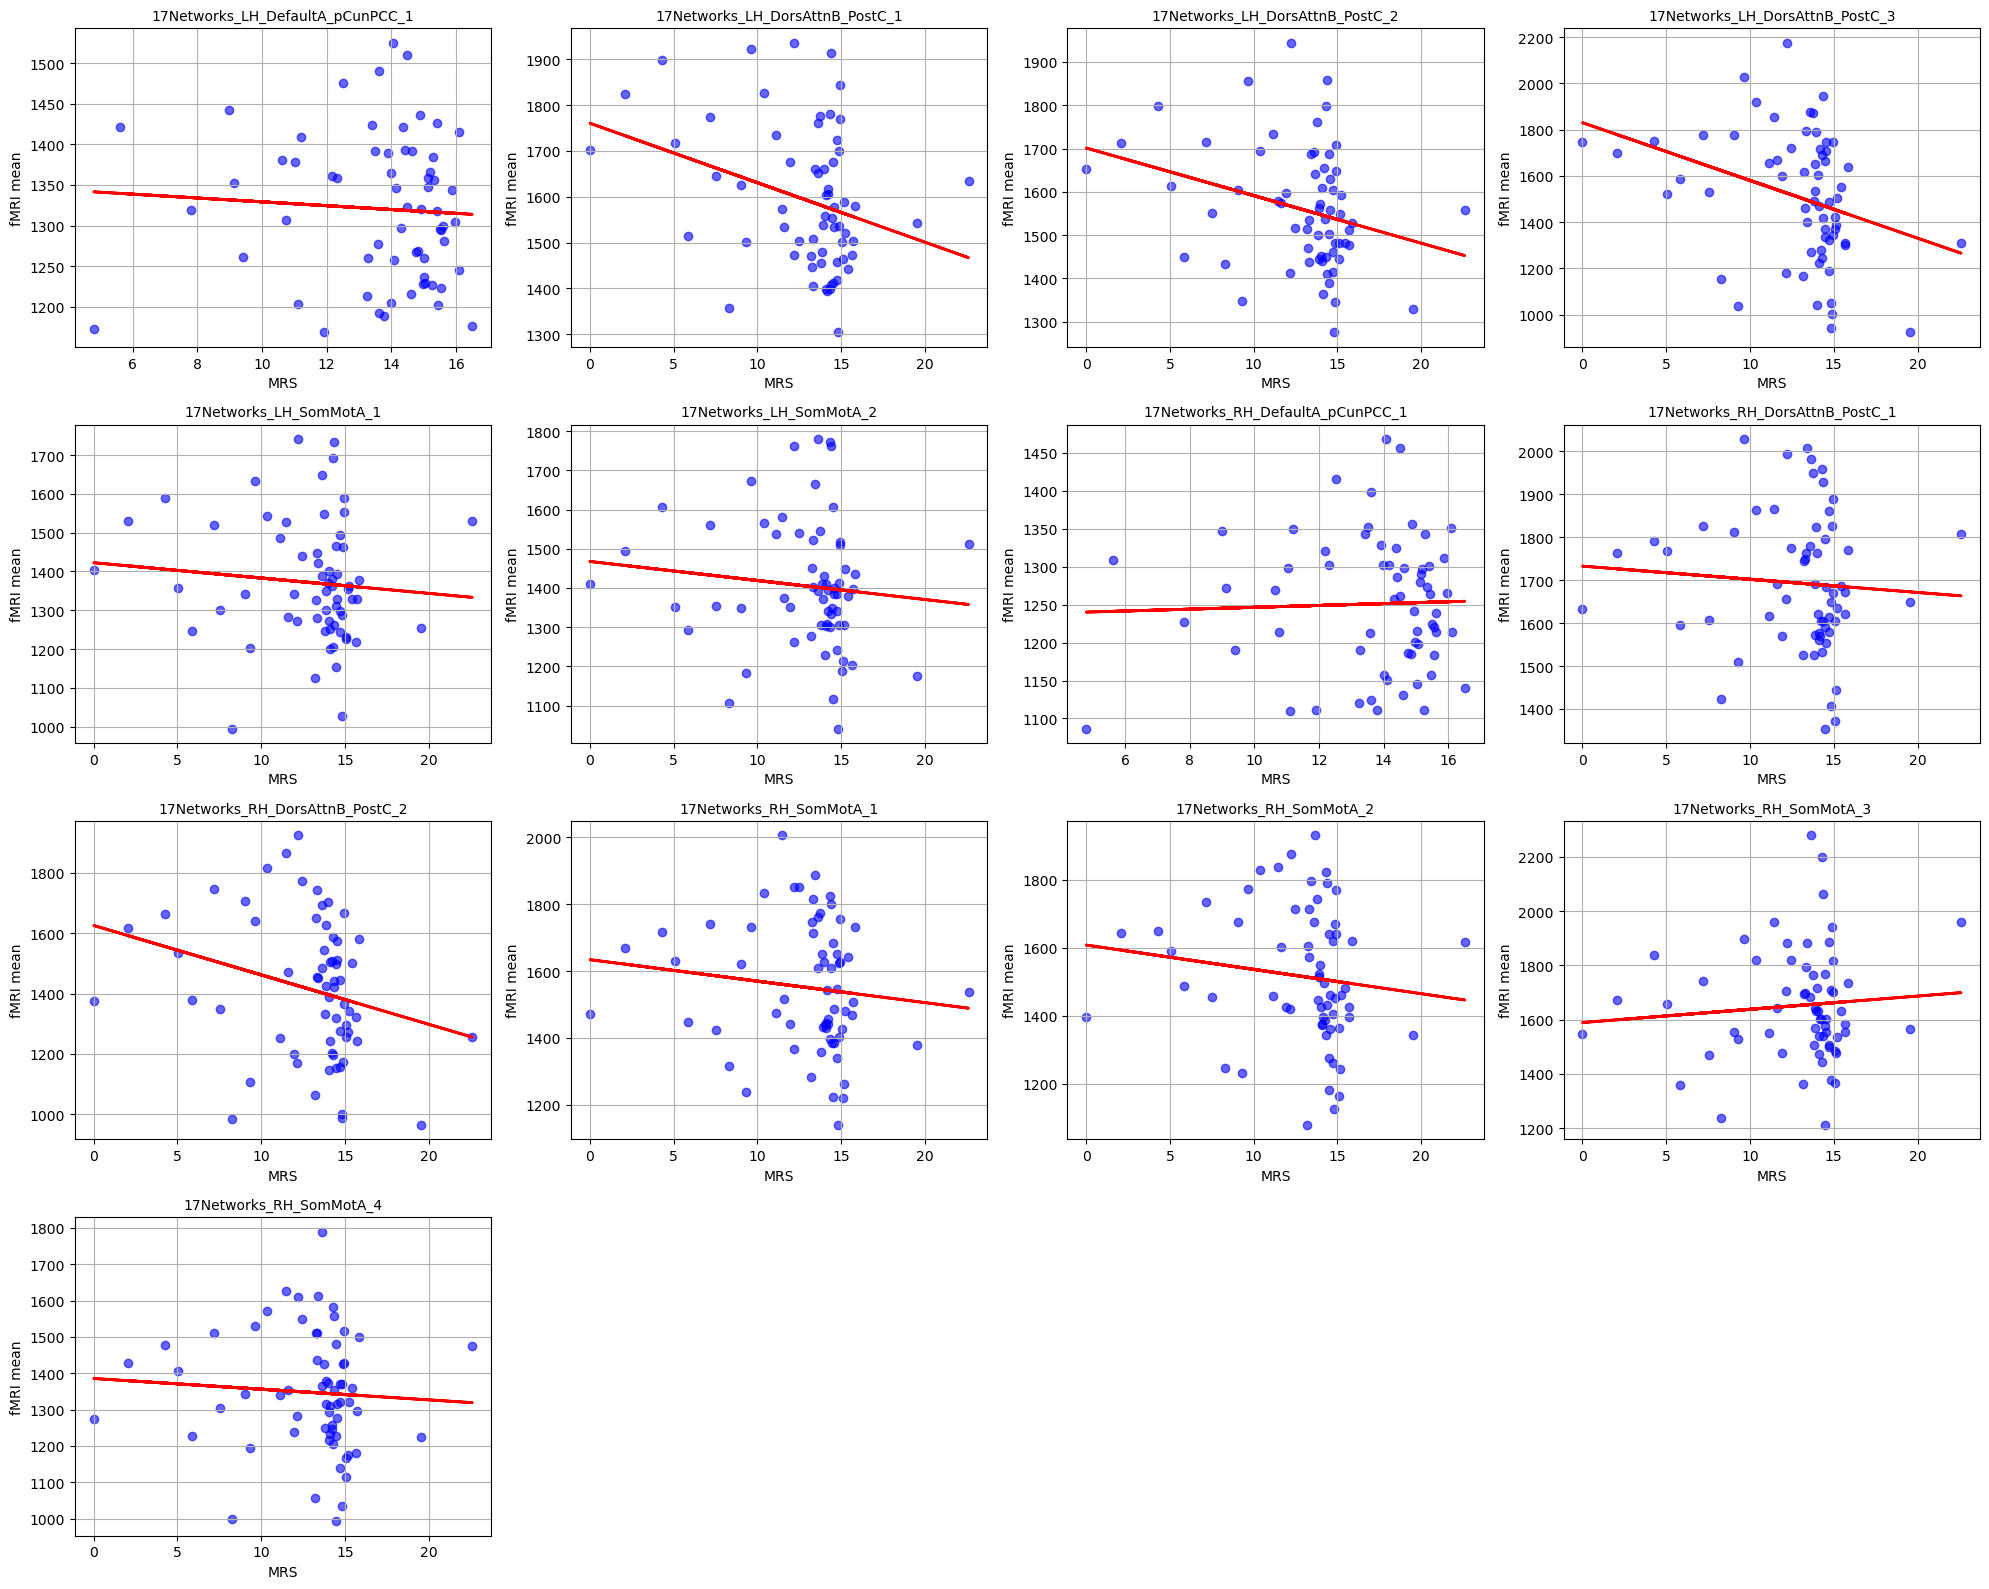

In [15]:
import numpy as np
import matplotlib.pyplot as plt
feature2 = "mean"

# Helper to pick MRS source
def get_mrs_column(roi_name):
    return "pcc mrs" if "DefaultA_pCunPCC" in roi_name else "sma mrs"

# Filter no GSR data
df_no_gsr = data[data["gsr"] == "no gsr"]
rois = sorted(df_no_gsr["roi"].unique())
n_rois = len(rois)

# Subplot config
cols = 4
rows = int(np.ceil(n_rois / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, roi_name in enumerate(rois):
    ax = axes[i]
    mrs_col = get_mrs_column(roi_name)
    df_plot = df_no_gsr[df_no_gsr["roi"] == roi_name][[mrs_col, "mean"]].dropna()

    x = df_plot[mrs_col].values
    y = df_plot[feature2].values

    if len(x) < 2:
        ax.set_visible(False)
        continue

    # Fit line
    slope, intercept = np.polyfit(x, y, 1)
    line = slope * x + intercept

    # Plot
    ax.scatter(x, y, color="blue", alpha=0.6)
    ax.plot(x, line, color="red", linewidth=2, label=f"y = {slope:.2f}x + {intercept:.2f}")
    ax.set_title(roi_name, fontsize=10)
    ax.set_xlabel("MRS")
    ax.set_ylabel(f"fMRI {feature2}")
    ax.grid(True)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


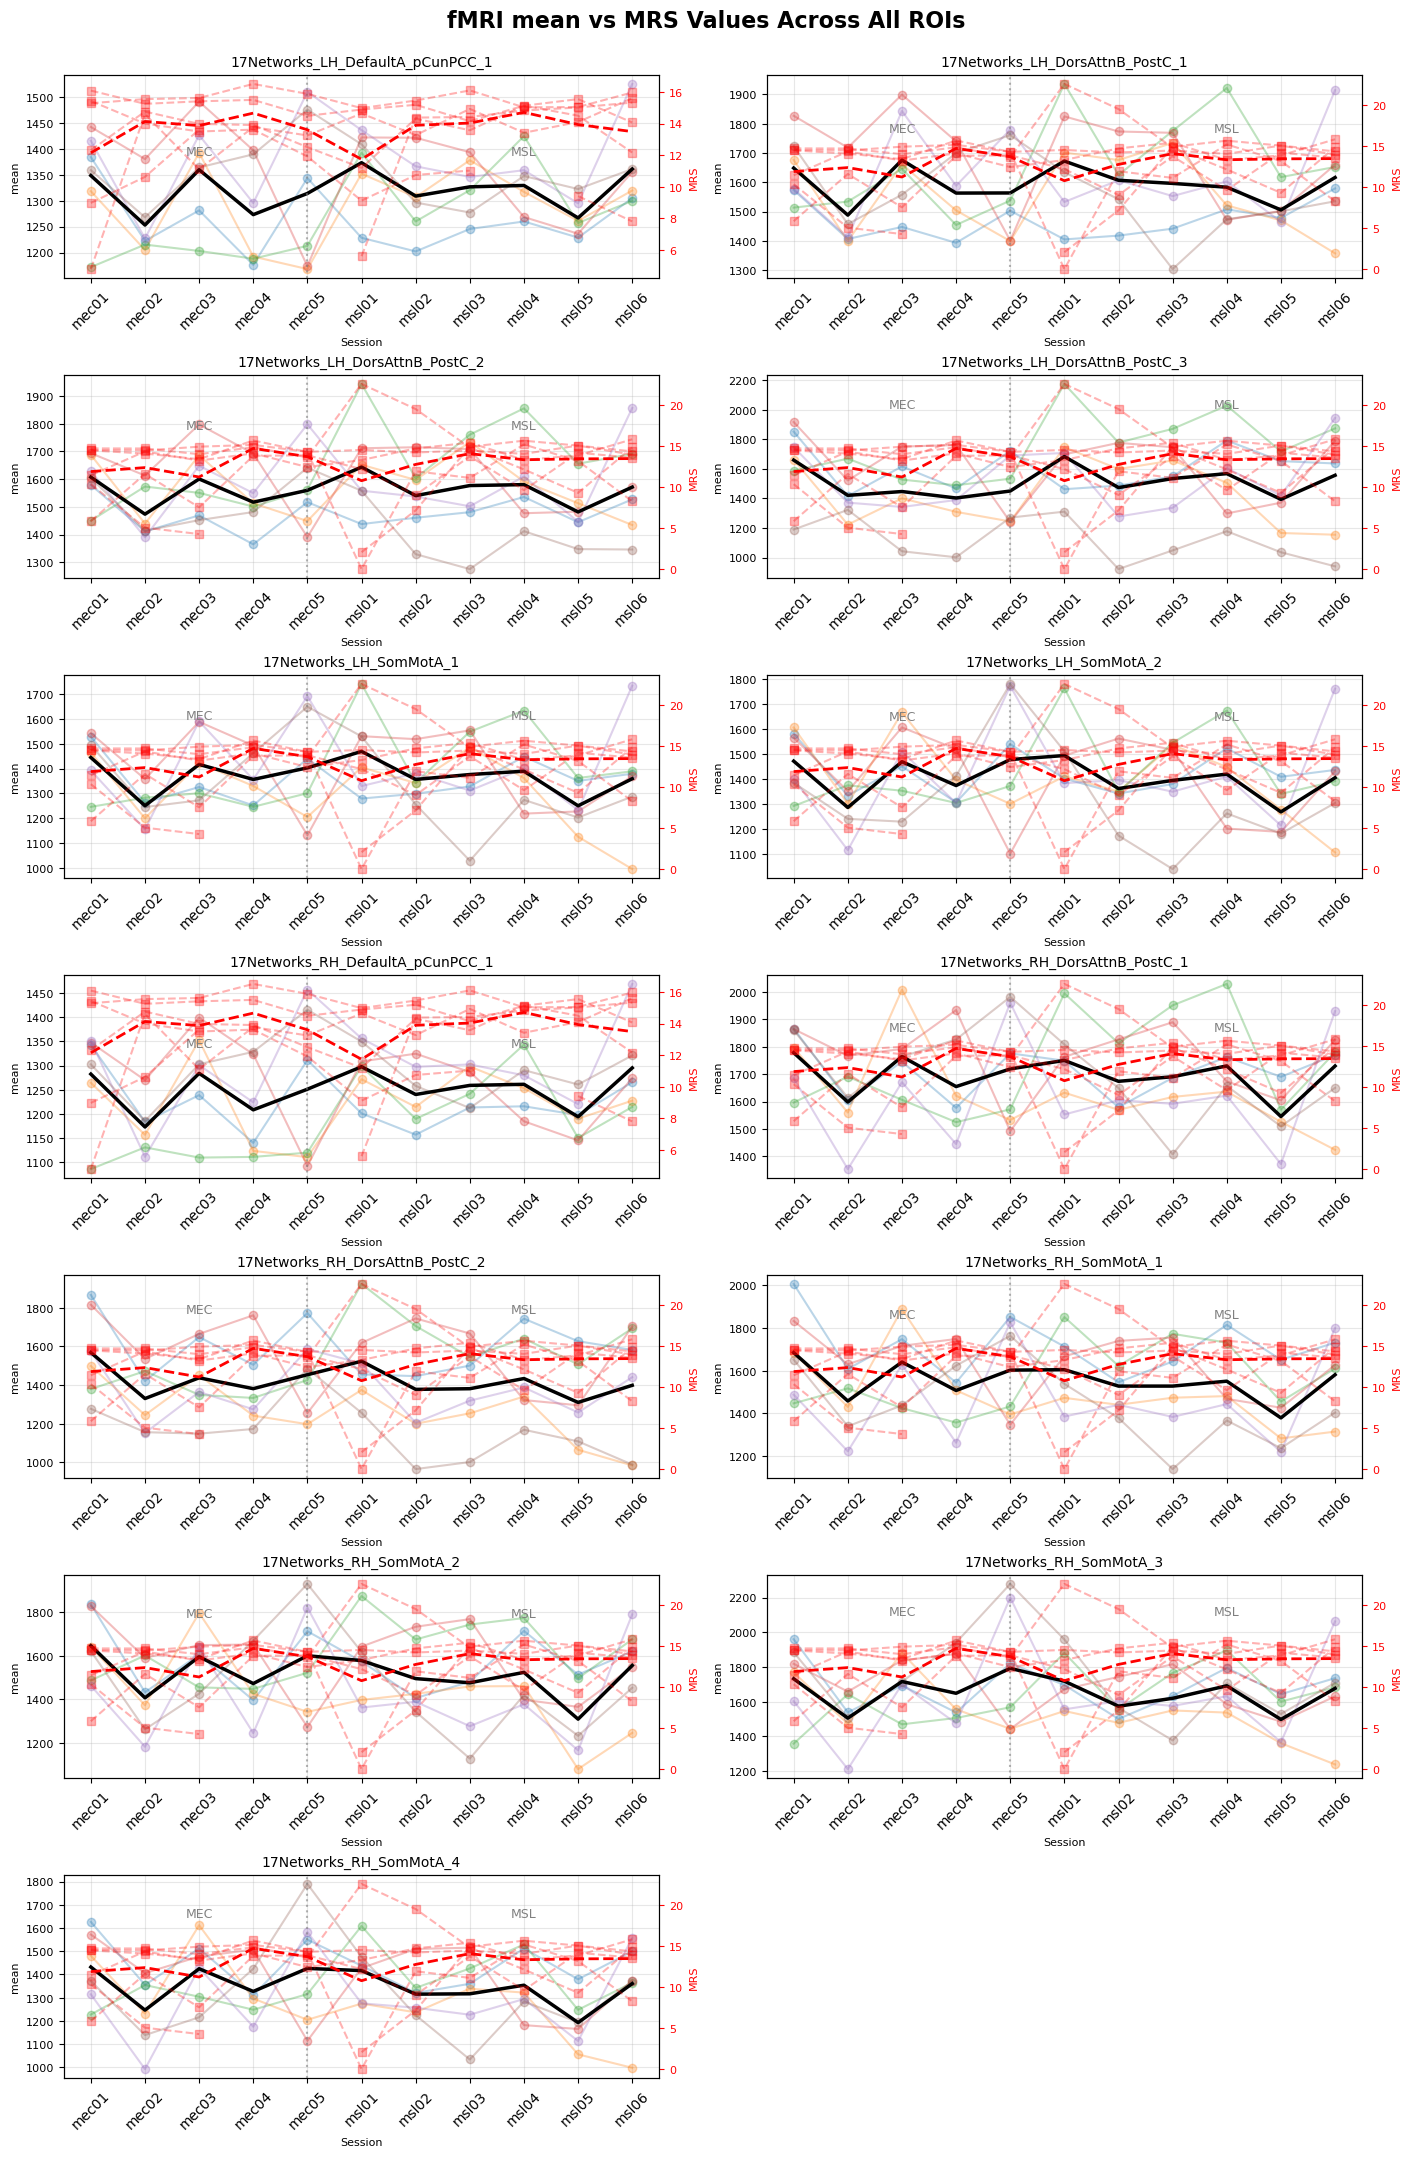

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
feature1 = "mean"

df = data

# Filter to 'no gsr' data only
df_no_gsr = df[df["gsr"] == "no gsr"].reset_index()  # ensure 'session' is a column

# Define session groupings
mec_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("mec")], key=lambda x: int(x[-2:]))
msl_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("msl")], key=lambda x: int(x[-2:]))
all_sessions = mec_sessions + msl_sessions  # combine both groups for one x-axis

# Define ROI list and subjects
rois = sorted(df_no_gsr["roi"].unique())
subjects = sorted(df_no_gsr["subject"].unique())

# Helper to determine MRS region
def get_mrs_column(roi_name):
    return "pcc mrs" if "DefaultA_pCunPCC" in roi_name else "sma mrs"

# --- Create figure grid ---
n_rois = len(rois)
n_cols = 2
n_rows = (n_rois + 1) // n_cols  # ceil division for uneven last row

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), constrained_layout=True)
axes = axes.flatten()  # make it easy to index through axes

# --- Plot each ROI ---
for i, roi in enumerate(rois):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    mrs_col = get_mrs_column(roi)
    mean_lines = []
    mrs_lines = []

    for subj in subjects:
        subj_data = df_no_gsr[
            (df_no_gsr["roi"] == roi)
            & (df_no_gsr["subject"] == subj)
            & (df_no_gsr["session"].isin(all_sessions))
        ].set_index("session").reindex(all_sessions)

        ax1.plot(subj_data.index, subj_data[feature1], marker="o", alpha=0.3)
        ax2.plot(subj_data.index, subj_data[mrs_col], marker="s", linestyle="--", alpha=0.3, color="red")

        mean_lines.append(subj_data[feature1].values)
        mrs_lines.append(subj_data[mrs_col].values)

    # Average across subjects
    mean_avg = pd.DataFrame(mean_lines, columns=all_sessions).mean(axis=0)
    mrs_avg = pd.DataFrame(mrs_lines, columns=all_sessions).mean(axis=0)

    # Plot averages
    ax1.plot(all_sessions, mean_avg, color="black", linewidth=2.5)
    ax2.plot(all_sessions, mrs_avg, color="red", linewidth=2.0, linestyle="--")

    # Add vertical divider between MEC and MSL
    ax1.axvline(x=mec_sessions[-1], color="gray", linestyle=":", alpha=0.6)
    ax1.text(mec_sessions[len(mec_sessions)//2], ax1.get_ylim()[1]*0.9, "MEC", ha="center", fontsize=9, color="gray")
    ax1.text(msl_sessions[len(msl_sessions)//2], ax1.get_ylim()[1]*0.9, "MSL", ha="center", fontsize=9, color="gray")

    # Style
    ax1.set_title(roi, fontsize=10)
    ax1.tick_params(axis="y", colors="black", labelsize=8)
    ax2.tick_params(axis="y", colors="red", labelsize=8)
    ax1.tick_params(axis="x", labelrotation=45)
    ax1.grid(alpha=0.3)
    ax1.set_xlabel("Session", fontsize=8)
    ax1.set_ylabel(feature1, fontsize=8)
    ax2.set_ylabel("MRS", fontsize=8, color="red")

# Remove any empty subplots (if number of ROIs is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- Global title ---
fig.suptitle(f"fMRI {feature1} vs MRS Values Across All ROIs", fontsize=16, fontweight="bold", y=1.02)
plt.show()


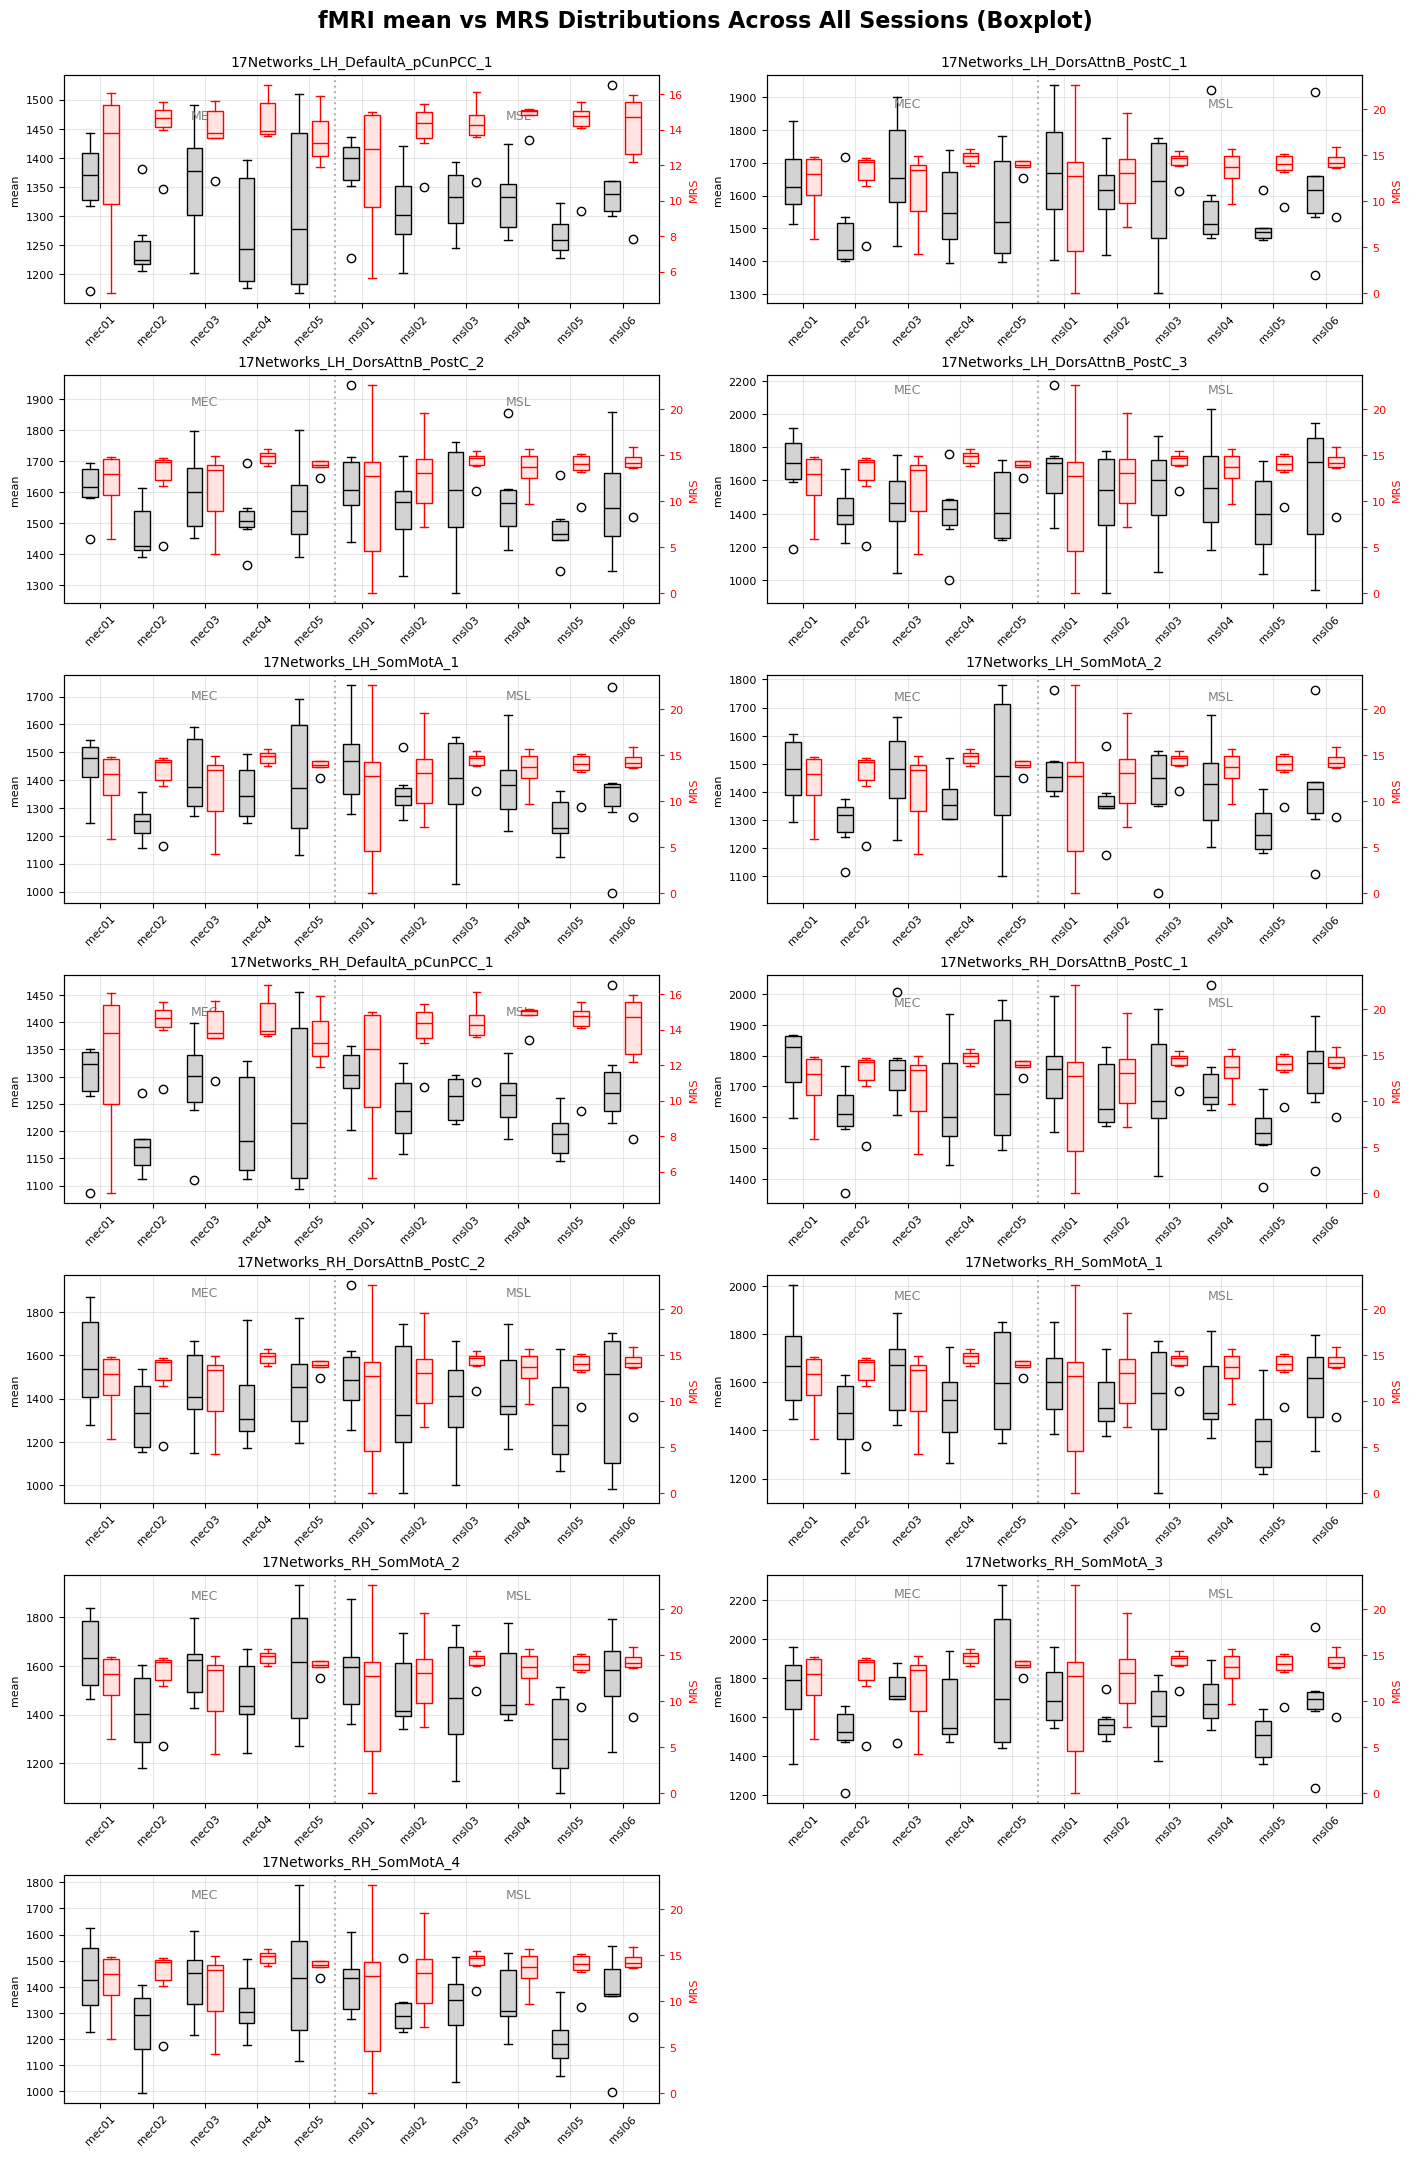

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
feature3 = "mean"

df = data

# Filter to 'no gsr' data only
df_no_gsr = df[df["gsr"] == "no gsr"].reset_index()

# Define session groupings
mec_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("mec")], key=lambda x: int(x[-2:]))
msl_sessions = sorted([s for s in df_no_gsr["session"].unique() if s.startswith("msl")], key=lambda x: int(x[-2:]))
all_sessions = mec_sessions + msl_sessions

# Define ROI list and subjects
rois = sorted(df_no_gsr["roi"].unique())
subjects = sorted(df_no_gsr["subject"].unique())

def get_mrs_column(roi_name):
    return "pcc mrs" if "DefaultA_pCunPCC" in roi_name else "sma mrs"

# --- Create figure grid ---
n_rois = len(rois)
n_cols = 2
n_rows = (n_rois + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), constrained_layout=True)
axes = axes.flatten()

# --- Plot each ROI ---
for i, roi in enumerate(rois):
    ax1 = axes[i]
    ax2 = ax1.twinx()
    mrs_col = get_mrs_column(roi)

    feature_data = []
    mrs_data = []

    for sess in all_sessions:
        sess_data = df_no_gsr[(df_no_gsr["roi"] == roi) & (df_no_gsr["session"] == sess)]
        feature_data.append(sess_data[feature3].dropna().values)
        mrs_data.append(sess_data[mrs_col].dropna().values)

    # Define x positions
    x_positions = np.arange(len(all_sessions))
    offset = 0.2  # to separate the two boxes visually

    # Plot boxplots
    bp1 = ax1.boxplot(feature_data, positions=x_positions - offset,
                      widths=0.3, patch_artist=True,
                      boxprops=dict(facecolor="lightgray", color="black"),
                      medianprops=dict(color="black"),
                      whiskerprops=dict(color="black"),
                      capprops=dict(color="black"))

    bp2 = ax2.boxplot(mrs_data, positions=x_positions + offset,
                      widths=0.3, patch_artist=True,
                      boxprops=dict(facecolor="mistyrose", color="red"),
                      medianprops=dict(color="red"),
                      whiskerprops=dict(color="red"),
                      capprops=dict(color="red"))

    # Add MEC–MSL divider
    ax1.axvline(x=len(mec_sessions) - 0.5, color="gray", linestyle=":", alpha=0.6)
    ax1.text(len(mec_sessions)/2 - 0.5, ax1.get_ylim()[1]*0.95, "MEC", ha="center", fontsize=9, color="gray")
    ax1.text(len(mec_sessions) + len(msl_sessions)/2, ax1.get_ylim()[1]*0.95, "MSL", ha="center", fontsize=9, color="gray")

    # Style
    ax1.set_title(roi, fontsize=10)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(all_sessions, rotation=45, fontsize=8)
    ax1.set_ylabel(feature3, fontsize=8, color="black")
    ax2.set_ylabel("MRS", fontsize=8, color="red")
    ax1.tick_params(axis="y", colors="black", labelsize=8)
    ax2.tick_params(axis="y", colors="red", labelsize=8)
    ax1.grid(alpha=0.3)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- Global title ---
fig.suptitle(f"fMRI {feature3} vs MRS Distributions Across All Sessions (Boxplot)", fontsize=16, fontweight="bold", y=1.02)
plt.show()
